In [1]:
# %set_env SCIPY_USE_PROPACK=1

import config

import numpy as np
import ctypes
import sys
from numpy.linalg import lstsq
from numba import jit, njit
import matplotlib.pyplot as plt
import pickle

from scipy.sparse import *
from scipy.sparse.linalg import lsmr, lsqr, eigs

import importlib
import FORBILD

importlib.reload(FORBILD)
importlib.reload(config)

from FORBILD import forbild_sinogram, forbild_sinogram_noquad, discrete_phantom
from config import *

np.set_printoptions(threshold=sys.maxsize, precision=3, linewidth=480)


def forward_with_matrix(img, mat):
    img = img.reshape(nx*ny, 1)
    mat = mat.reshape(nnp*nu, nx*ny)

    proj = mat @ img

    return proj.reshape(nnp, nu)

def backward_from_projection(sino, mat):
    sino = sino.reshape(nnp*nu, 1)
    mat = mat.reshape(nnp*nu, nx*ny)
    
    img, residual, _, _ = lstsq(mat, sino, rcond=None)

    print("Residual: ", residual)

    return img.reshape(nx, ny)

def backward_from_projection_hex(sino, mat):
    sino = sino.reshape(nnp*nu, 1)
    mat = mat.reshape((nnp*nu, -1))
    
    img, residual, rank, _ = lstsq(mat, sino, rcond=None)

    print("Residual: ", residual, "Rank: ", rank)

    return img

def hex_mat_presolve(mat):
    mat = mat.reshape(nnp*nu, -1)
    mat1 = np.zeros((nnp*nu, nl*nc-np.floor(nl/2).astype(int)), dtype=np.float64)
    pos = pos1 = 0

    for i in range(nl):
        if i%2 == 0:
            mat1[:, pos1:pos1+nc] = mat[:, pos:pos+nc]
            pos1 += nc
            pos += nc
        else:
            mat1[:, pos1:pos1+nc-1] = mat[:, pos:pos+nc-1]
            pos1 += nc-1
            pos += nc
    
    return mat1

def post_process_hex(img):
    img1 = np.zeros((nl, nc), dtype=np.float64)
    pos = 0

    for i in range(nl):
        if i%2 == 0:
            img1[i] = img[pos:pos+nc].ravel()
            pos += nc
        else:
            img1[i, :-1] = img[pos:pos+nc-1].ravel()
            pos += nc-1
    
    return img1

In [10]:
A_B0_ref_sparse = pickle.load(open("./matrixes/A_B0_ref_sparse.pkl", 'rb'))
A_B0_sparse = pickle.load(open("./matrixes/A_B0_sparse_" + str(nx) + '_' + str(ny) + "_" + str(nnp) + "_"+ str(nu) + ".pkl", 'rb'))
A_B1_ref_sparse = load_npz("./matrixes/A_B1_ref_sparse_" + str(nx) + '_' + str(ny) + "_" + str(nnp) + "_"+ str(nu) + ".npz")
A_B1_ref_sparse = bsr_array(A_B1_ref_sparse)
A_B1_sparse = pickle.load(open("./matrixes/A_B1_sparse_" + str(nx) + '_' + str(ny) + "_" + str(nnp) + "_"+ str(nu) + ".pkl", 'rb'))
A_Hl_sparse = pickle.load(open("./matrixes/A_Hl_sparse_" + str(nl) + '_' + str(nc) + "_" + str(nnp) + "_"+ str(nu) + ".pkl", 'rb'))
A_H0_sparse = pickle.load(open("./matrixes/A_H0_sparse_" + str(H0_nl) + '_' + str(H0_nc) + "_" + str(nnp) + "_"+ str(nu) + ".pkl", 'rb'))

In [16]:
y = A_B1_ref_sparse.sum(axis=1).reshape((nnp, nu))
y2 = A_B1_sparse.sum(axis=1).reshape((nnp, nu))
y= np.asarray(y)

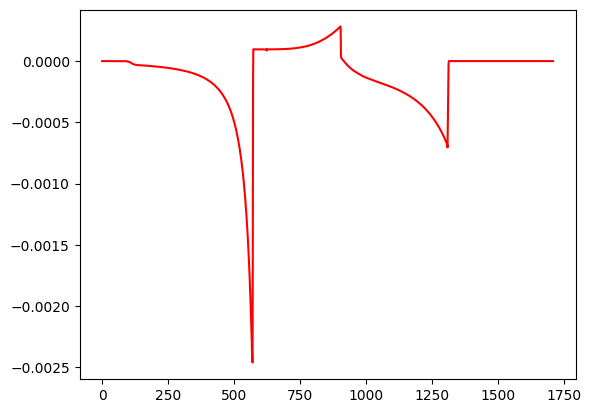

In [21]:
x = np.arange(nu)

plt.plot(x, y[30]-y2[30], color='r')
# plt.plot(x, y2[0].T, color='r')
plt.show()

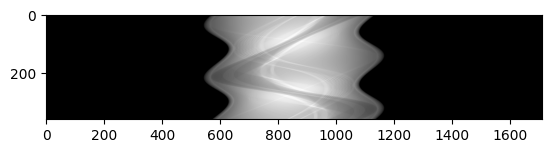

In [19]:
sino_360_1710 = np.load(open('./matrixes/FORBILD_sinogram_360_1710.dat', 'rb'))

plt.imshow(sino_360_1710, cmap='gray')

# Reconstuction

2 90 20.03451083234144
0.21995025065509 -0.029140485951236743 0.06406813378391261


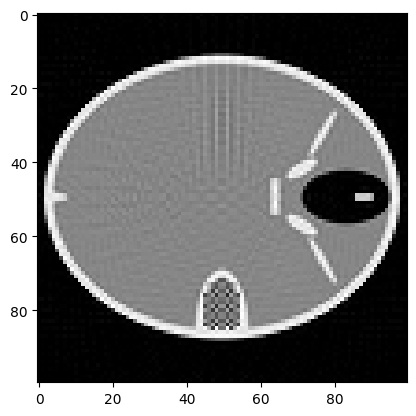

In [8]:
# img_sample_180_855 = backward_from_projection(sino_180_855, ref_mat)

x_B0_ref, istop, itn, normr = lsmr(A_B0_ref_sparse, sino_180_855.ravel(), atol=1e-8, btol=1e-8)[:4]

print(istop, itn, normr)

x_B0_ref = x_B0_ref.reshape(nx, ny)

print(np.max(x_B0_ref), np.min(x_B0_ref), np.mean(x_B0_ref))

plt.imshow(x_B0_ref, cmap='gray', vmax = 0.2, vmin = 0)

2 142 14.495094216168972
2.2556734046933067 -0.38388048177777473 0.6411905066157124


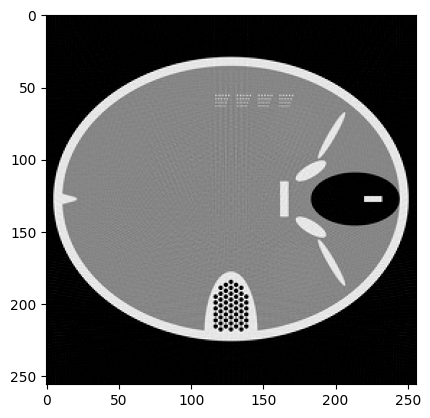

In [21]:
x_B0, istop, itn, normr = lsqr(A_B0_sparse, sino_360_1710.ravel())[:4]

print(istop, itn, normr)

x_B0 = x_B0.reshape(nx, ny)*10/dx/dy

print(np.max(x_B0), np.min(x_B0), np.mean(x_B0))

plt.imshow(x_B0, cmap='gray', vmax = 2, vmin = 0)

2 518 11.99424597372539
2.8123253344767742 -0.8669983317529936 0.641190815167959


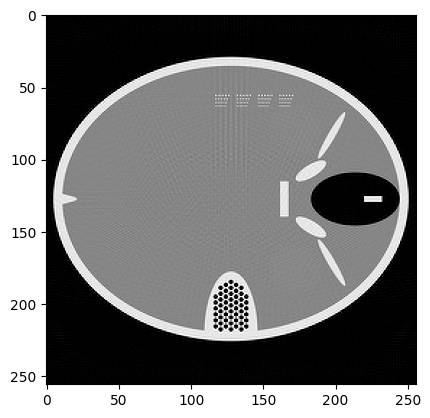

In [20]:
x_B1_ref, istop, itn, normr = lsmr(A_B1_ref_sparse, sino_360_1710.ravel(), atol=1e-8, btol=1e-8)[:4]

print(istop, itn, normr)

x_B1_ref = x_B1_ref.reshape(nx, ny)*10/dx/dy

print(np.max(x_B1_ref), np.min(x_B1_ref), np.mean(x_B1_ref))

plt.imshow(x_B1_ref, cmap='gray', vmax = 2, vmin = 0)

2 522 11.994148992633441
2.812352391401709 -0.8670024099317198 0.6411905718150143


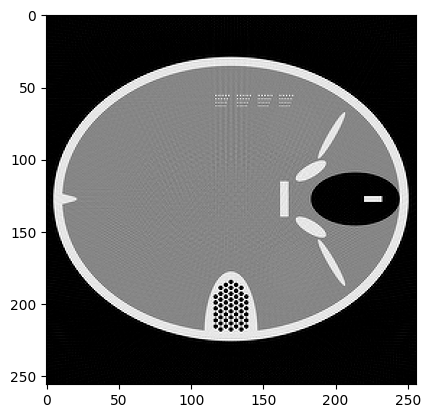

In [6]:
x_B1, istop, itn, normr = lsmr(A_B1_sparse, sino_360_1710.ravel(), atol=1e-8, btol=1e-8)[:4]

print(istop, itn, normr)

x_B1 = x_B1.reshape(nx, ny)*10/dx/dy

print(np.max(x_B1), np.min(x_B1), np.mean(x_B1))

plt.imshow(x_B1, cmap='gray', vmax = 2, vmin = 0)

In [6]:
# hex_mat = hex_mat_presolve(hex_mat)
# hex_img = backward_from_projection_hex(sino_180_855, hex_mat)

x_Hl, istop, itn, normr = lsmr(A_Hl_sparse, sino_360_1710.ravel(), atol=1e-8, btol=1e-8)[:4]

print(istop, itn, normr)

x_Hl = x_Hl.reshape(nl, nc) * 10 / (dt*dt*1.5/np.sqrt(3))

print(np.max(x_Hl), np.min(x_Hl), np.mean(x_Hl))

plt.imshow(x_Hl, cmap='gray', vmax = 2, vmin = 0)

2 268 12.132780260917562
0.03912991662033903 -0.013615741653542691 0.009853103049312188


2 187 14.821548331369971
2.3566041907594886 -0.4120028450328983 0.6287565362786377


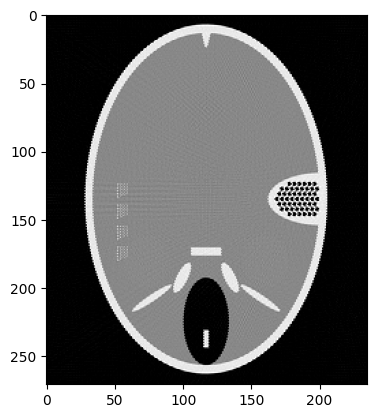

In [22]:
x_H0, istop, itn, normr = lsmr(A_H0_sparse, sino_360_1710.ravel(), atol=1e-8, btol=1e-8)[:4]

print(istop, itn, normr)

x_H0 = x_H0[:H0_nl*H0_nc].reshape(H0_nl, H0_nc) * 10 / (dt*dt*1.5/np.sqrt(3))

print(np.max(x_H0), np.min(x_H0), np.mean(x_H0))

plt.imshow(x_H0, cmap='gray', vmax = 2, vmin = 0)

# Evaluation

In [22]:
eval_points = 1000

0.6409497250000002 1.81


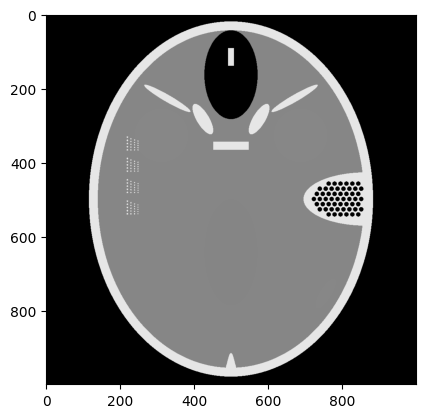

In [23]:
x, step = np.linspace(-50, 50, endpoint=False, num=eval_points, retstep=True, dtype=np.float64)
x += step / 2

xcoords, ycoords = np.meshgrid(x, np.flip(x))
base = discrete_phantom(xcoords, ycoords)
base = base.reshape((eval_points, eval_points))

print(np.mean(base), np.max(base))

plt.imshow(base, cmap='gray', vmin = 0, vmax = 2)

In [25]:
def pixel_value(x, y, pmap):
    eps = 1e-10

    x1 = x + (nx / 2) * dx
    y1 = y + (ny / 2) * dy

    x1 = np.floor(x1/dx).astype(int)
    y1 = np.floor(y1/dy).astype(int)

    return pmap[x1, y1]

def interpolate_ref(x, y, pmap):
    x0 = x + (nx / 2) * dx
    y0 = y + (ny / 2) * dy

    x0 = x0 / dx + 0.5
    y0 = y0 / dy + 0.5

    pmap = np.pad(pmap, pad_width=1, mode='edge')

    x1 = np.floor(x0).astype(int)
    x2 = x1+1
    y1 = np.floor(y0).astype(int)
    y2 = y1+1
    
    return pmap[x1, y1] * (x2-x0) * (y2-y0) + pmap[x1, y2] * (x2-x0) * (y0-y1) + pmap[x2, y1] * (x0-x1) * (y2-y0) + pmap[x2, y2] * (x0-x1) * (y0-y1)

def bilinear_value_pixel(x, y, pmap):
    x0 = x + (nx / 2) * dx
    y0 = y + (ny / 2) * dy

    x0 = x0 / dx + 0.5
    y0 = y0 / dy + 0.5

    pmap = np.pad(pmap, pad_width=1, mode='edge')

    x1 = np.floor(x0).astype(int)
    x2 = x1+1
    y1 = np.floor(y0).astype(int)
    y2 = y1+1


    return pmap[x1, y1] * (x2-x0) * (y2-y0) + pmap[x1, y2] * (x2-x0) * (y0-y1) + pmap[x2, y1] * (x0-x1) * (y2-y0) + pmap[x2, y2] * (x0-x1) * (y0-y1)

In [26]:
x, step = np.linspace(-50, 50, endpoint=False, num=eval_points, retstep=True, dtype=np.float64)
x += step / 2

xcoords, ycoords = np.meshgrid(x, np.flip(x))
eval_pixel = pixel_value(xcoords, ycoords, x_B0).reshape((eval_points, eval_points))
# inte_pixel = interpolate_ref(xcoords, ycoords, x_B0).reshape((eval_points, eval_points))

diff_pixel = np.fabs(eval_pixel-base)
# diff_pinte = np.fabs(inte_pixel-base)

print(np.max(diff_pixel))
print(np.mean(diff_pixel**2))
# print(np.max(diff_pinte))
# print(np.mean(diff_pinte**2))

plt.imsave("./eval_results/eval_x_B0.png", eval_pixel, cmap='gray', vmin = 0, vmax = 2)
plt.imsave("./eval_results/diff_x_B0.png", diff_pixel, cmap='gray', vmin = 0, vmax = 0.4)
# plt.imsave("./eval_results/diff_x_B0_inte.png", diff_pinte, cmap='gray', vmin = 0, vmax = 0.4)

2.219290120512437
0.014500111491426887


In [8]:
x, step = np.linspace(-50, 50, endpoint=False, num=eval_points, retstep=True, dtype=np.float64)
x += step / 2

xcoords, ycoords = np.meshgrid(x, np.flip(x))
eval_bilinear = bilinear_value_pixel(xcoords, ycoords, x_B1)

eval_bilinear = eval_bilinear.reshape((eval_points, eval_points))

diff_bilinear = np.fabs(eval_bilinear-base)

print(np.mean(eval_bilinear), np.max(diff_bilinear))
print(np.mean(diff_bilinear**2))

plt.imsave("./eval_results/eval_x_B1.png", eval_bilinear, cmap='gray', vmin = 0, vmax = 2)
plt.imsave("./eval_results/diff_x_B1.png", diff_bilinear, cmap='gray', vmin = 0, vmax = 0.4)

0.6411887195638875 1.3666272407331277
0.00798340945174034


In [ ]:
x, step = np.linspace(-50, 50, endpoint=False, num=eval_points, retstep=True, dtype=np.float64)
x += step / 2

xcoords, ycoords = np.meshgrid(x, np.flip(x))
eval_ref = pixel_value(xcoords, ycoords, x_B0_ref).reshape((eval_points, eval_points))
# inte_ref = interpolate_ref(xcoords, ycoords, x_B0_ref).reshape((eval_points, eval_points))

diff_ref = np.fabs(eval_ref-base)
# diff_inte = np.fabs(inte_ref-base)

print(np.max(diff_ref))
print(np.mean(diff_ref**2))
# print(np.max(diff_inte))
# print(np.mean(diff_inte**2))

plt.imsave("./eval_results/eval_x_B0_ref.png", eval_ref, cmap='gray', vmin = 0, vmax = 2)
plt.imsave("./eval_results/diff_x_B0_ref.png", diff_ref, cmap='gray', vmin = 0, vmax = 0.4)
# plt.imsave("./eval_results/diff_x_B0_ref_inte.png", diff_inte, cmap='gray', vmin = 0, vmax = 0.4)

In [27]:
x, step = np.linspace(-50, 50, endpoint=False, num=eval_points, retstep=True, dtype=np.float64)
x += step / 2

xcoords, ycoords = np.meshgrid(x, np.flip(x))
eval_B1_ref = bilinear_value_pixel(xcoords, ycoords, x_B1_ref)

eval_B1_ref = eval_B1_ref.reshape((eval_points, eval_points))

diff_B1_ref = np.fabs(eval_B1_ref-base)

print(np.mean(eval_B1_ref), np.max(diff_B1_ref))
print(np.mean(diff_B1_ref**2))

plt.imsave("./eval_results/eval_x_B1_ref.png", eval_B1_ref, cmap='gray', vmin = 0, vmax = 2)
plt.imsave("./eval_results/diff_x_B1_ref.png", diff_B1_ref, cmap='gray', vmin = 0, vmax = 0.4)

0.6411889631093401 1.366787726587933
0.00798347281045561


In [27]:
h_dy = dt / 2
h_dx = dt * np.sqrt(3)

def l2y(l):
    return (l - (nl - 1) / 2) * h_dy

def c2x_outer(c):
    return (c - (nc - 1) / 2) * h_dx

def c2x_inner(c):
    return (c - (nc - 2) / 2) * h_dx

def x2c_outer(x):
    return x / h_dx + (nc-1)/2

def x2c_inner(x):
    return x / h_dx + (nc-2)/2

def distsq(x, y, hx, hy):
    return (x - hx) ** 2 + (y - hy) ** 2

def abscross(x1, y1, x2, y2):
    return np.fabs(x1*y2 - x2*y1)

def p_area(p1, p2, p3):
    return abscross(p1[0]-p2[0], p1[1]-p2[1], p1[0]-p3[0], p1[1]-p3[1])

def hex_value_evaluate(x, y, mat):
    target = np.array([x, y])
    val = 0

    l = y / h_dy + (nl - 1) / 2

    lf = np.floor(l).astype(int)
    lc = lf + 1

    c = x2c_outer(x)
    cinner = x2c_inner(x)

    cf = np.floor(c).astype(int)
    cc = cf + 1

    cif = np.floor(cinner).astype(int)
    cic = cif + 1

    outerf = np.bitwise_and(lc, 1).astype(bool)
    outerc = np.logical_not(outerf)

    l1 = l2 = lf
    l3 = l4 = lc

    c1 = cf * outerf + cif * outerc
    c2 = cc * outerf + cic * outerc
    c3 = cf * outerc + cif * outerf
    c4 = cc * outerc + cic * outerf

    hcenters = np.zeros((9, 3, x.shape[0], x.shape[1]), dtype = np.float64) # x, y, v
    tri = np.zeros((x.shape[0], x.shape[1], 3, 3), dtype = np.float64)

    hcenters[1, 0] = hcenters[5, 0] = c2x_outer(cf) * outerf + c2x_inner(cif) * outerc
    hcenters[2, 0] = hcenters[6, 0] = c2x_outer(cc) * outerf + c2x_inner(cic) * outerc
    hcenters[3, 0] = hcenters[7, 0] = c2x_outer(cf) * outerc + c2x_inner(cif) * outerf
    hcenters[4, 0] = hcenters[8, 0] = c2x_outer(cc) * outerc + c2x_inner(cic) * outerf

    hcenters[1, 1] = hcenters[2, 1] = l2y(lf)
    hcenters[5, 1] = hcenters[6, 1] = l2y(lf+2)
    hcenters[3, 1] = hcenters[4, 1] = l2y(lc)
    hcenters[7, 1] = hcenters[8, 1] = l2y(lc-2)

    hcenters[1, 2] = mat[l1, c1]
    hcenters[2, 2] = mat[l2, c2]
    hcenters[3, 2] = mat[l3, c3]
    hcenters[4, 2] = mat[l4, c4]
    hcenters[5, 2] = mat[l1+2, c1]
    hcenters[6, 2] = mat[l2+2, c2]
    hcenters[7, 2] = mat[l3-2, c3]
    hcenters[8, 2] = mat[l4-2, c4]

    rtilt = hcenters[3, 0] > hcenters[1, 0]

    cond1 = distsq(x, y, hcenters[7, 0], hcenters[7, 1]) < distsq(x, y, hcenters[6, 0], hcenters[6, 1])
    cond2 = distsq(x, y, hcenters[5, 0], hcenters[5, 1]) < distsq(x, y, hcenters[8, 0], hcenters[8, 1])

    t236 = (cond1 == False) & rtilt
    t237 = cond1 & rtilt
    t145 = cond2 & (rtilt == False)
    t148 = (cond2 == False) & (rtilt == False)

    hcenters = np.transpose(hcenters, (2, 3, 0, 1))

    # tmp = np.zeros(x.shape, dtype=str)
    # tmp[t236] = '#'
    # tmp[t237] = 'X'
    # tmp[t145] = '*'
    # tmp[t148] = 'O'
    # print(tmp)

    tri[t237] = hcenters[t237][:, [2,3,7]]
    tri[t236] = hcenters[t236][:, [2,3,6]]
    tri[t145] = hcenters[t145][:, [1,4,5]]
    tri[t148] = hcenters[t148][:, [1,4,8]]

    tri = np.transpose(tri, (2, 3, 0, 1))

    val += (tri[0, 2] * abscross(x-tri[1, 0], y-tri[1, 1], x-tri[2, 0], y-tri[2, 1]))
    val += (tri[1, 2] * abscross(x-tri[0, 0], y-tri[0, 1], x-tri[2, 0], y-tri[2, 1]))
    val += (tri[2, 2] * abscross(x-tri[0, 0], y-tri[0, 1], x-tri[1, 0], y-tri[1, 1]))

    sum = abscross(x-tri[1, 0], y-tri[1, 1], x-tri[2, 0], y-tri[2, 1]) + abscross(x-tri[0, 0], y-tri[0, 1], x-tri[2, 0], y-tri[2, 1]) + abscross(x-tri[0, 0], y-tri[0, 1], x-tri[1, 0], y-tri[1, 1])

    return val / (dt*dt*np.sqrt(3)/2)


In [11]:
x, step = np.linspace(-50, 50, endpoint=False, num=eval_points, retstep=True, dtype=np.float64)
x += step / 2

xcoords, ycoords = np.meshgrid(x, np.flip(x))
eval_hex = hex_value_evaluate(xcoords, ycoords, x_Hl)

diff_hex = np.fabs(base-eval_hex)

print(np.mean(eval_hex))
print(np.mean(diff_hex**2))

plt.imsave("./eval_results/eval_x_Hl.png", eval_hex, cmap='gray', vmin = 0, vmax = 2)
plt.imsave("./eval_results/diff_x_Hl.png", diff_hex, cmap='gray', vmin = 0, vmax = 0.4)

0.6411865620986805
0.008202593595471097


In [56]:
h0_dy = H0_dt * 3 / 2
h0_dx = H0_dt * np.sqrt(3)

def h0_value_evaluate(x, y, mat):
    res = np.zeros(x.shape, dtype=np.float64)

    l = y / h0_dy + (H0_nl - 1) / 2
    lf = np.floor(l).astype(int)
    yf = (lf - (H0_nl - 1) / 2) * h0_dy
    outerc = np.bitwise_and(lf, 1).astype(bool)
    outerf = np.logical_not(outerc)

    c = x / h0_dx + (H0_nc-1)/2
    cof = np.floor(c).astype(int)
    xof = (cof - (H0_nc - 1) / 2) * h0_dx

    p1 = np.logical_and ( outerf , ((y - yf) < 0.5 * H0_dt) )
    p2 = np.logical_and ( outerf , np.logical_and ((y - yf) >= 0.5 * H0_dt , (y - yf) < H0_dt) )
    p3 = np.logical_and ( outerf , ((y - yf) >= H0_dt) )

    p4 = np.logical_and ( outerc , ((y - yf) < 0.5 * H0_dt) )
    p5 = np.logical_and ( outerc , np.logical_and ((y - yf) >= 0.5 * H0_dt , (y - yf) < H0_dt) )
    p6 = np.logical_and ( outerc , ((y - yf) >= H0_dt) )

    q1 = (x - xof) < 0.5 * h0_dx
    q2 = np.logical_not(q1)

    dist1 = distsq(x, y, xof, yf)
    dist2 = distsq(x, y, xof+h0_dx, yf)
    dist3 = distsq(x, y, xof+h0_dx/2, yf+h0_dy)

    dist4 = distsq(x, y, xof+h0_dx/2, yf)
    dist5 = distsq(x, y, xof, yf+h0_dy)
    dist6 = distsq(x, y, xof+h0_dx, yf+h0_dy)

    r1 = np.where(dist1 < dist3, mat[lf, cof], mat[lf+1, cof])
    r2 = np.where(dist2 < dist3, mat[lf, cof+1], mat[lf+1, cof])
    r3 = np.where(dist4 < dist5, mat[lf, cof], mat[lf+1, cof])
    r4 = np.where(dist4 < dist6, mat[lf, cof], mat[lf+1, cof+1])

    res[p1&q1] = mat[lf[p1&q1], cof[p1&q1]]
    res[p1&q2] = mat[lf[p1&q2], cof[p1&q2] + 1]
    
    res[p2&q1] = r1[p2&q1]
    res[p2&q2] = r2[p2&q2]

    res[p3] = mat[lf[p3] + 1, cof[p3]]

    res[p4] = mat[lf[p4], cof[p4]]

    res[p5&q1] = r3[p5&q1]
    res[p5&q2] = r4[p5&q2]

    res[p6&q1] = mat[lf[p6&q1] + 1, cof[p6&q1]]
    res[p6&q2] = mat[lf[p6&q2] + 1, cof[p6&q2] + 1]

    ar1 = np.where(dist1 < dist3, "1", "3")
    ar2 = np.where(dist2 < dist3, "2", "3")
    ar3 = np.where(dist4 < dist5, "4", "5")
    ar4 = np.where(dist4 < dist6, "4", "6")

    # deb = np.zeros(x.shape, dtype=str)
    # deb[p1&q1] = 'L'
    # deb[p1&q2] = 'R'
    
    # deb[p2&q1] = ar1[p2&q1]
    # deb[p2&q2] = ar2[p2&q2]

    # deb[p3] = 'M'

    # deb[p4] = 'M'

    # deb[p5&q1] = ar3[p5&q1]
    # deb[p5&q2] = ar4[p5&q2]

    # deb[p6&q1] = 'L'
    # deb[p6&q2] = 'R'

    # print(yf)
    # print(xof)
    # print(deb)

    return res

In [59]:
x, step = np.linspace(-50, 50, endpoint=False, num=eval_points, retstep=True, dtype=np.float64)
x += step / 2

xcoords, ycoords = np.meshgrid(x, np.flip(x))
eval_hex = h0_value_evaluate(xcoords, ycoords, x_H0)

diff_hex = np.fabs(base-eval_hex)

print(np.mean(eval_hex))
print(np.mean(diff_hex**2))

plt.imsave("./eval_results/eval_x_H0.png", eval_hex, cmap='gray', vmin = 0, vmax = 2)
plt.imsave("./eval_results/diff_x_H0.png", diff_hex, cmap='gray', vmin = 0, vmax = 0.4)

0.6502116808365723
0.014897590092805654


# Analysis

In [6]:
from scipy.sparse.linalg import lsmr, lsqr, svds, norm

In [13]:
B0_lg = svds(A_B0_sparse, k=1, which='LM', return_singular_vectors=False, solver='propack')
print(B0_lg)
H0_lg = svds(A_H0_sparse, k=1, which='LM', return_singular_vectors=False, solver='propack')
print(H0_lg)


[1184.701]
[1162.824]


In [ ]:
B0_sm = svds(A_B0_sparse, k=1, which='SM', return_singular_vectors=False, solver='propack')
print(B0_sm)
H0_sm = svds(A_H0_sparse, k=1, which='SM', return_singular_vectors=False, solver='propack')
print(H0_sm)

In [21]:
def radius_power_method(B):
    x = np.random.randn(B.shape[1], 1)
    x = x / np.linalg.norm(x)
    rad = 0

    while True:
        y = B.transpose() @ (B @ x)
        y_norm = np.linalg.norm(y)
        if(abs(rad - y_norm) < power_iterations_tol):
            break
        print("abs(rad - y_norm): ", abs(rad - y_norm))
        rad = y_norm
        x = y / rad
    
    return rad, x

def radius_power_method2(B, trBtB):
    x = np.random.randn(B.shape[1], 1)
    x = x / np.linalg.norm(x)
    rad = 0

    while True:
        y = x - 1/trBtB * (B.transpose() @ (B @ x))
        y_norm = np.linalg.norm(y)
        if(abs(rad - y_norm) < power_iterations_tol):
            break
        print("abs(rad - y_norm): ", abs(rad - y_norm), end='\t')
        rad = y_norm
        x = y / rad
        print(f"Current estimate of gap: {trBtB * (1 - rad)}")
    
    return rad, x

power_iterations_tol = 1e-11

In [18]:
radius, rad_vec = radius_power_method(A_B0_sparse)
trMtM = radius

abs(rad - y_norm):  13924.377722451563
abs(rad - y_norm):  431736.45437456574
abs(rad - y_norm):  313824.3903019978
abs(rad - y_norm):  179901.95095951296
abs(rad - y_norm):  228396.05341692537
abs(rad - y_norm):  153720.91641298425
abs(rad - y_norm):  58719.849233082496
abs(rad - y_norm):  17115.736294181086
abs(rad - y_norm):  4568.927441207925
abs(rad - y_norm):  1190.937091652304
abs(rad - y_norm):  308.59024740732275
abs(rad - y_norm):  79.85080644278787
abs(rad - y_norm):  20.65665742661804
abs(rad - y_norm):  5.343553473940119
abs(rad - y_norm):  1.3823166443035007
abs(rad - y_norm):  0.35759542835876346
abs(rad - y_norm):  0.09250833606347442
abs(rad - y_norm):  0.023931631818413734
abs(rad - y_norm):  0.0061910622753202915
abs(rad - y_norm):  0.0016016173176467419
abs(rad - y_norm):  0.0004143351688981056
abs(rad - y_norm):  0.00010718870908021927
abs(rad - y_norm):  2.7729663997888565e-05
abs(rad - y_norm):  7.173279300332069e-06
abs(rad - y_norm):  1.855660229921341e-06
abs(

KeyboardInterrupt: 

In [19]:
print(trMtM)

1403515.8992169623


In [22]:
min_eigv, min_eigvec = radius_power_method2(A_B0_sparse, trMtM)
spectral_gap = trMtM * (1 - min_eigv)

abs(rad - y_norm):  0.9961055577849114	Current estimate of gap: 5465.911567458591
abs(rad - y_norm):  8.78944492214151e-05	Current estimate of gap: 5342.5503105234175
abs(rad - y_norm):  6.892966031624148e-05	Current estimate of gap: 5245.806436341948
abs(rad - y_norm):  5.854212507006018e-05	Current estimate of gap: 5163.64163303217
abs(rad - y_norm):  5.185316769851234e-05	Current estimate of gap: 5090.864887742545
abs(rad - y_norm):  4.705062021881368e-05	Current estimate of gap: 5024.828594197421
abs(rad - y_norm):  4.334890434720684e-05	Current estimate of gap: 4963.987717732481
abs(rad - y_norm):  4.035698694904166e-05	Current estimate of gap: 4907.346044905009
abs(rad - y_norm):  3.785756845686716e-05	Current estimate of gap: 4854.212345670102
abs(rad - y_norm):  3.571919119382816e-05	Current estimate of gap: 4804.079892922393
abs(rad - y_norm):  3.3856829633416297e-05	Current estimate of gap: 4756.561294234813
abs(rad - y_norm):  3.221243262152562e-05	Current estimate of gap: 4